In [57]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
from minisom import MiniSom  
from sklearn.cluster import KMeans

In [58]:
print("SOM Assignment")

SOM Assignment


In [59]:
chainlink = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))

In [60]:
chainlink
print(chainlink.shape)
d1=20
d2=25


(1000, 3)


In [66]:
chainlink_som_small = MiniSom(20, 25, 3, sigma=10, learning_rate=0.1,neighborhood_function='triangle',random_seed=10)
chainlink_som_small.train_random(chainlink, 10000)
chainlink_som_big = MiniSom(100, 60, 3, sigma=20, learning_rate=0.5)
chainlink_som_big.train_random(chainlink, 10000)

In [67]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec



In [68]:
# HIERARCHICAL CLUSTERING

In [69]:
from scipy import cluster


Ev Small SOM
0.002186519489115691
0.087
Mean of Quantization error:
0.0027331493613946137
Ev Big SOM
0.010040341403747769
0.001
Mean of Quantization error:
0.01255042675468471


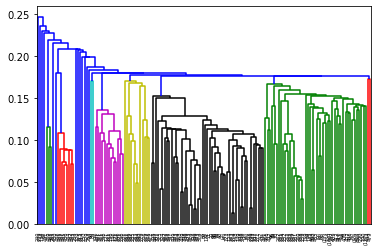

[[4.43000000e+02 4.68000000e+02 5.34342845e-03 2.00000000e+00]
 [4.18000000e+02 5.00000000e+02 6.95287812e-03 3.00000000e+00]
 [3.30000000e+02 3.55000000e+02 8.25597903e-03 2.00000000e+00]
 ...
 [1.34000000e+02 9.95000000e+02 2.29936967e-01 4.98000000e+02]
 [2.39000000e+02 9.96000000e+02 2.35740086e-01 4.99000000e+02]
 [2.40000000e+02 9.97000000e+02 2.47287835e-01 5.00000000e+02]]


In [70]:
chainlink_som_small.train_random(chainlink, 1000)

print("Ev Small SOM")
print(chainlink_som_small.quantization_error(chainlink))
print(chainlink_som_small.topographic_error(chainlink))
print("Mean of Quantization error:")
print(chainlink_som_small.quantization_error(chainlink)/d1*d2)


print("Ev Big SOM")
print(chainlink_som_big.quantization_error(chainlink))
print(chainlink_som_big.topographic_error(chainlink))

print("Mean of Quantization error:")
print(chainlink_som_big.quantization_error(chainlink)/d1*d2)




weights=chainlink_som_small.get_weights()
weights = chainlink_som_small.get_weights().reshape(d1*d2,-1) 





def hierarchy(weights):
    Z = cluster.hierarchy.linkage(weights,'single')
    d=cluster.hierarchy.dendrogram(Z,truncate_mode='level')
    #Y=cluster.hierarchy.single(weights)
    plt.show()
    print(Z)

    cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[2,10])
    labels=cutree[:,1]
    #print("Labeling",labels)

    #print(cutree)
    return labels

labels=hierarchy(weights)




In [71]:
def winners_labels(som,weights,labels):
    winners_labels = np.zeros(shape=(d1,d2))
    for cnt, xx in enumerate (weights):
        w = som.winner(xx)
        l = labels[cnt]
        winners_labels[w[0],w[1]] = l
    return winners_labels

def dif_matrix(label_matrix):
    dif_mat = np.zeros(shape=label_matrix.shape)
    for i,row in enumerate(label_matrix):
        for j,label in enumerate(row):
            if i < label_matrix.shape[0]-1 and label_matrix[i][j] != label_matrix[i+1][j]:
                dif_mat[i][j] = 1
            elif j < label_matrix.shape[1]-1 and label_matrix[i][j] != label_matrix[i][j+1]:
                dif_mat[i][j] = 1
    return dif_mat

dif_matrix(winners_labels(chainlink_som_small,weights,labels))

print(np.unique(dif_matrix(winners_labels(chainlink_som_small,weights,labels))))

[0. 1.]


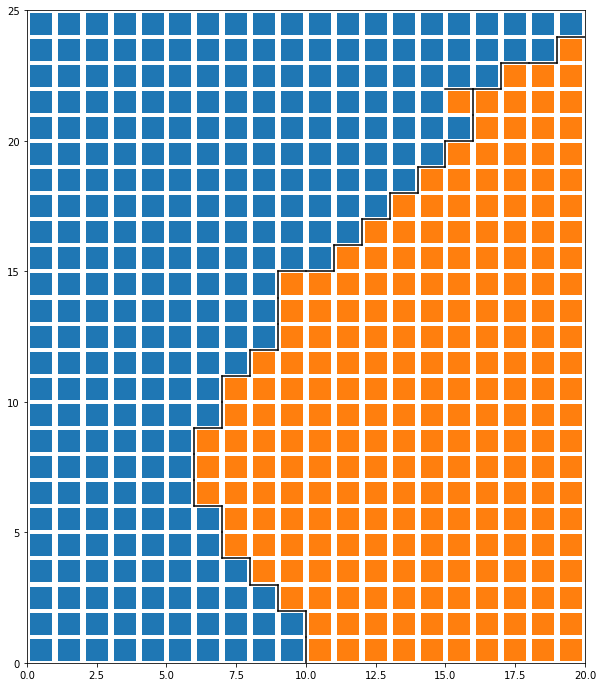

In [72]:
## import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_with_labelling(som, d1, d2, labels, coloring_labels, rweights, debug=False):

    plt.figure(figsize=(d1//2, d2//2))
    # Plotting the response for each pattern in the iris dataset
    #win_map = som.win_map(rweights)
    #plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    #plt.colorbar()
    # use different colors and markers for each label
    #markers = ['o', 's', 'D']
    colors = ['C' + str(i) for i in np.unique(coloring_labels)] #['C0', 'C1', 'C2', 'C3', 'C4']
    win_labels = winners_labels(som,rweights,labels)
    diff_mat_ = dif_matrix(win_labels)
    diff_mat = np.append(diff_mat_,np.ones((diff_mat_.shape[0],1)),axis=1)
    diff_mat = np.append(diff_mat,np.ones((1,diff_mat.shape[1])),axis=0)

    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner
        #w = xx
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[coloring_labels[cnt]],
                markeredgecolor=colors[coloring_labels[cnt]], markersize=20, markeredgewidth=2)
    def plot_borders(debug=False):
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(diff_mat):
            for j,v in enumerate(row):
                if i < diff_mat.shape[0]-1 and j < diff_mat.shape[1]-1:
                    if v != 0: 
                        # case where
                        # - -  -
                        # -[1] 1
                        # - -  -
                        # then draw horizontal line
                        if i > 0 and diff_mat[i-1][j] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                        # edge case where
                        # - - -
                        # [1] -
                        # - - -
                        # then draw horizontal line
                        elif i == 0 and j != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('green'))    
                        # case where
                        # - 0  1
                        # -[1] 0
                        # - -  -
                        # then draw horizontal line
                        elif i > 0 and diff_mat[i-1][j] == 0 and diff_mat[i][j+1] == 0 and diff_mat[i-1][j+1] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('blue'))
                        # case where
                        # - 1  -
                        # -[1] -
                        # - -  -
                        # then draw vertical line
                        if diff_mat[i][j+1] != 0:
                            plt.plot([i+1,i+1],[j+1,j+2], color=border_color('black'))
                        # edge case where
                        # - [1] -
                        # -  -  -
                        # then draw vertical line
                        if j == 0 and i != 0:
                            plt.plot([i+1,i+1],[j,j+1], color=border_color('brown'))    
                    # case where
                    # - -  -
                    # -[0] 1
                    # - 1  0
                    # then draw vertical line
                    elif diff_mat[i+1][j] != 0 and diff_mat[i][j+1] != 0 and diff_mat[i+1][j+1] == 0:
                        plt.plot([i+1,i+1],[j+1,j+2], color=border_color('purple'))
    plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    plt.show()

d1 = 20
d2 = 25
rweights = chainlink_som_small.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
Z = cluster.hierarchy.linkage(rweights,'ward')
labels = cluster.hierarchy.cut_tree(Z, n_clusters=2)
labels = [l[0] for l in labels]
plot_with_labelling(chainlink_som_small,d1,d2,labels,labels,rweights,debug=False)

In [73]:
# K-Means clustering

In [74]:


starting_weights = chainlink_som_small.get_weights()
print(starting_weights)
weightskM = chainlink_som_small.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset

#x=weights[1]
#print(weights[x])
labels_kM = KMeans(n_clusters=2,random_state=0)
y_kmeans2 = labels_kM.fit(weightskM)
print("Y_Kmeans2",y_kmeans2)
#KMlabels=y_kmeans2.labels_

#print(KMlabels)


[[[-5.50065830e-04 -1.90871395e-01 -1.01122009e+00]
  [ 8.27380136e-03 -2.44773612e-01 -9.89528451e-01]
  [ 1.11308663e-02 -3.05936178e-01 -9.66854198e-01]
  ...
  [ 1.82027456e-02 -8.56834633e-01  3.84725846e-01]
  [ 2.15203462e-02 -8.42426430e-01  4.30575321e-01]
  [ 2.61382315e-02 -8.30211576e-01  4.83803331e-01]]

 [[-9.98358287e-03 -9.31851867e-02 -1.00542928e+00]
  [-1.24519550e-02 -1.72006985e-01 -9.86915411e-01]
  [-7.90218419e-03 -2.53714613e-01 -9.65008925e-01]
  ...
  [ 2.26088541e-02 -8.20576618e-01  4.30252351e-01]
  [ 2.68354970e-02 -8.09690848e-01  4.76543077e-01]
  [ 3.55169831e-02 -7.92415757e-01  5.31849813e-01]]

 [[-2.39910365e-02 -1.38753998e-02 -9.98127684e-01]
  [-2.97665212e-02 -1.03651706e-01 -9.84082631e-01]
  [-2.58514504e-02 -1.85287612e-01 -9.66102019e-01]
  ...
  [ 1.96978245e-02 -7.59486694e-01  4.75915421e-01]
  [ 3.15656299e-02 -7.63230670e-01  5.36720677e-01]
  [ 4.46370943e-02 -7.43574752e-01  5.99792065e-01]]

 ...

 [[ 9.58551049e-01  8.24626788e-01

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

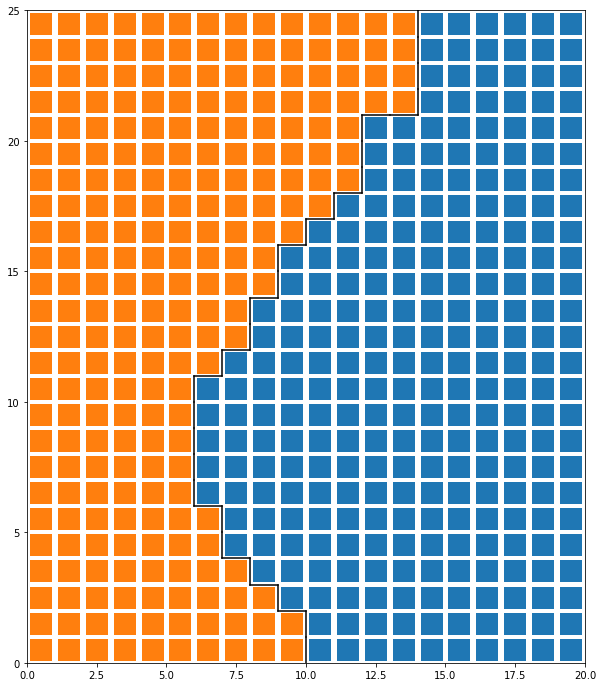

In [75]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(weightskM)
labels_kM = kmeans.labels_
print(labels_kM)
plot_with_labelling(chainlink_som_small,d1,d2,labels_kM,labels_kM,rweights,debug=False)